Before running the code, please download the required package first like torch, numpy ...

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import init
import math
import torch.nn as nn
import torch.nn.functional as F
import os

d:\Anaconda\envs\GPU_Pytorchpy39\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


The code below will automatically create a path './data' and download MNIST dataset

In [2]:
transform = transforms.Compose(
    [torchvision.transforms.ToTensor()])

batch_size = 64

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

Define the hardware tuning property <--- Hardware-aware training

In [3]:
def lorentzian_curve(x, A, x0, gamma):
    return -2 * A / (1 + ((x - x0) / gamma)**2) +A
def lorentzian_curve_derivative(x, A, x0, gamma):
    return 2 * A * (x - x0) / (gamma**2 * (1 + ((x - x0) / gamma)**2)**2)
def lorentzian_inv(y, A, x0, gamma):
    return gamma * ((A + y)/(A - y)) ** (1/2) + x0

Self defines the convolution layer and linear layer <--- Now we are optimizing the tuning currents/voltages, which differs directly optimizing the weights ! This is a very important step !

In [4]:
from torch.nn.modules.conv import _ConvNd
from torch.nn.common_types import _size_1_t, _size_2_t, _size_3_t
from torch.nn.modules.utils import _pair
from typing import Optional, List, Tuple, Union

In [5]:
class Conv2dLorentz(_ConvNd):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = True,
        padding_mode: str = 'zeros',  # TODO: refine this type
        device=None,
        dtype=None
    ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        kernel_size_ = _pair(kernel_size)
        stride_ = _pair(stride)
        padding_ = padding if isinstance(padding, str) else _pair(padding)
        dilation_ = _pair(dilation)
        super().__init__(
            in_channels, out_channels, kernel_size_, stride_, padding_, dilation_,
            False, _pair(0), groups, bias, padding_mode, **factory_kwargs)

    def _conv_forward(self, input: torch.Tensor, weight: torch.Tensor, bias: Optional[torch.Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self._conv_forward(input, lorentzian_curve(self.weight, 1, 0, 0.15), self.bias) ### <--- Here self.weight is voltage or current

In [6]:
class LinearLorentz(torch.nn.Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(lorentzian_curve(self.weight, 1, 0, 0.15), a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(lorentzian_curve(self.weight, 1, 0, 0.15))
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(input, lorentzian_curve(self.weight, 1, 0, 0.15), self.bias) ### <--- Here self.weight is voltage or current

    def extra_repr(self) -> str:
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'


In [7]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.norm1 = nn.BatchNorm2d(6)
        self.norm2 = nn.BatchNorm2d(16)
        self.norm3 = nn.BatchNorm1d(120)
        self.norm4 = nn.BatchNorm1d(84)

    def forward(self,x):

        x = F.max_pool2d(F.relu(self.norm1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.norm2(self.conv2(x))), (2, 2))

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.norm4(x)
        x = F.relu(x)   
        x = self.fc3(x)

        return x

    def apply_constraints(self):
        self.conv1.cuda().weight.data = torch.clamp(self.conv1.cuda().weight.data, -0.999, 0.999)
        self.conv2.cuda().weight.data = torch.clamp(self.conv2.cuda().weight.data, -0.999, 0.999)
        self.fc1.cuda().weight.data = torch.clamp(self.fc1.cuda().weight.data, -0.999, 0.999)
        self.fc2.cuda().weight.data = torch.clamp(self.fc2.cuda().weight.data, -0.999, 0.999)
        self.fc3.cuda().weight.data = torch.clamp(self.fc3.cuda().weight.data, -0.999, 0.999)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net = LeNet5()
net.to(device)

cuda:0


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [8]:
class LeNet5_Lorentz(nn.Module):
    def __init__(self):
        super(LeNet5_Lorentz, self).__init__()

        self.conv1 = Conv2dLorentz(1, 6, 5, padding=2)
        self.conv2 = Conv2dLorentz(6, 16, 5)
        self.fc1 = LinearLorentz(16*5*5, 120)
        self.fc2 = LinearLorentz(120, 84)
        self.fc3 = LinearLorentz(84, 10)
        self.norm1 = nn.BatchNorm2d(6)
        self.norm2 = nn.BatchNorm2d(16)
        self.norm3 = nn.BatchNorm1d(120)
        self.norm4 = nn.BatchNorm1d(84)

    def forward(self,x):

        x = F.max_pool2d(F.relu(self.norm1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.norm2(self.conv2(x))), (2, 2))
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.norm4(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

    def apply_constraints(self):
        self.conv1.cuda().weight.data = torch.clamp(self.conv1.cuda().weight.data, min=0)
        self.conv2.cuda().weight.data = torch.clamp(self.conv2.cuda().weight.data, min=0)
        self.fc1.cuda().weight.data = torch.clamp(self.fc1.cuda().weight.data, min=0)
        self.fc2.cuda().weight.data = torch.clamp(self.fc2.cuda().weight.data, min=0)
        self.fc3.cuda().weight.data = torch.clamp(self.fc3.cuda().weight.data, min=0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net_Lorentz = LeNet5_Lorentz()
net_Lorentz.to(device)

cuda:0


LeNet5_Lorentz(
  (conv1): Conv2dLorentz(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2dLorentz(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): LinearLorentz(in_features=400, out_features=120, bias=True)
  (fc2): LinearLorentz(in_features=120, out_features=84, bias=True)
  (fc3): LinearLorentz(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

### SAT in-silico (This work)

In [52]:
from sam import SAM
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

In [53]:
net = LeNet5()
net.to(device)
net_Lorentz = LeNet5_Lorentz()
net_Lorentz.to(device)
net_Lorentz.conv1.weight.data = lorentzian_inv(net.conv1.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.conv2.weight.data = lorentzian_inv(net.conv2.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.fc1.weight.data = lorentzian_inv(net.fc1.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.fc2.weight.data = lorentzian_inv(net.fc2.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.fc3.weight.data = lorentzian_inv(net.fc3.weight.data, A=1, x0=0, gamma=0.15)
conv1_flat = net_Lorentz.conv1.cpu().weight.detach().numpy().flatten()
conv2_flat = net_Lorentz.conv2.cpu().weight.detach().numpy().flatten()
fc1_flat = net_Lorentz.fc1.cpu().weight.detach().numpy().flatten()
fc2_flat = net_Lorentz.fc2.cpu().weight.detach().numpy().flatten()
fc3_flat = net_Lorentz.fc3.cpu().weight.detach().numpy().flatten()
total_weight = np.hstack((conv1_flat, conv2_flat, fc1_flat, fc2_flat, fc3_flat))
net_Lorentz.to(device)
base_optimizer = torch.optim.Adam
optimizer = SAM(net_Lorentz.parameters(), rho=1e-4, base_optimizer=base_optimizer,lr=0.001,adaptive=False)

for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        ### First forward propagation
        outputs = net_Lorentz(inputs)
        loss0 = criterion(outputs, labels)
        loss = loss0
        optimizer.zero_grad()
        loss.backward()
        optimizer.first_step(zero_grad=True)
        ### Second forward propagation
        outputsSAM = net_Lorentz(inputs)
        lossSAM0 = criterion(outputsSAM, labels)
        lossSAM = lossSAM0
        lossSAM.backward()
        optimizer.second_step(zero_grad=True) 
        running_loss += loss.item()
        if i % 600 == 599:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 600:.3f}')
            running_loss = 0.0

    net_Lorentz.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net_Lorentz(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy 10000 test images: {100 * correct / total} %')
print('Finished Training')

[1,   600] loss: 0.134
Accuracy 10000 test images: 98.42 %
[2,   600] loss: 0.054
Accuracy 10000 test images: 98.64 %
[3,   600] loss: 0.040
Accuracy 10000 test images: 98.75 %
[4,   600] loss: 0.034
Accuracy 10000 test images: 98.83 %
[5,   600] loss: 0.026
Accuracy 10000 test images: 98.86 %
[6,   600] loss: 0.024
Accuracy 10000 test images: 98.87 %
[7,   600] loss: 0.019
Accuracy 10000 test images: 98.87 %
[8,   600] loss: 0.015
Accuracy 10000 test images: 98.91 %
[9,   600] loss: 0.016
Accuracy 10000 test images: 98.74 %
[10,   600] loss: 0.015
Accuracy 10000 test images: 98.93 %
[11,   600] loss: 0.013
Accuracy 10000 test images: 98.92 %
[12,   600] loss: 0.012
Accuracy 10000 test images: 98.87 %
[13,   600] loss: 0.009
Accuracy 10000 test images: 98.93 %
[14,   600] loss: 0.010
Accuracy 10000 test images: 98.91 %
[15,   600] loss: 0.007
Accuracy 10000 test images: 98.93 %
[16,   600] loss: 0.008
Accuracy 10000 test images: 99.0 %
[17,   600] loss: 0.008
Accuracy 10000 test images

In [54]:
conv1_flat = net_Lorentz.conv1.cpu().weight.detach().numpy().flatten()
conv2_flat = net_Lorentz.conv2.cpu().weight.detach().numpy().flatten()
fc1_flat = net_Lorentz.fc1.cpu().weight.detach().numpy().flatten()
fc2_flat = net_Lorentz.fc2.cpu().weight.detach().numpy().flatten()
fc3_flat = net_Lorentz.fc3.cpu().weight.detach().numpy().flatten()
total_weight = np.hstack((conv1_flat, conv2_flat, fc1_flat, fc2_flat, fc3_flat))
print(np.min(lorentzian_curve(total_weight, A=1, x0=0, gamma=0.15)))
print(np.max(lorentzian_curve(total_weight, A=1, x0=0, gamma=0.15)))

-1.0
0.8929129


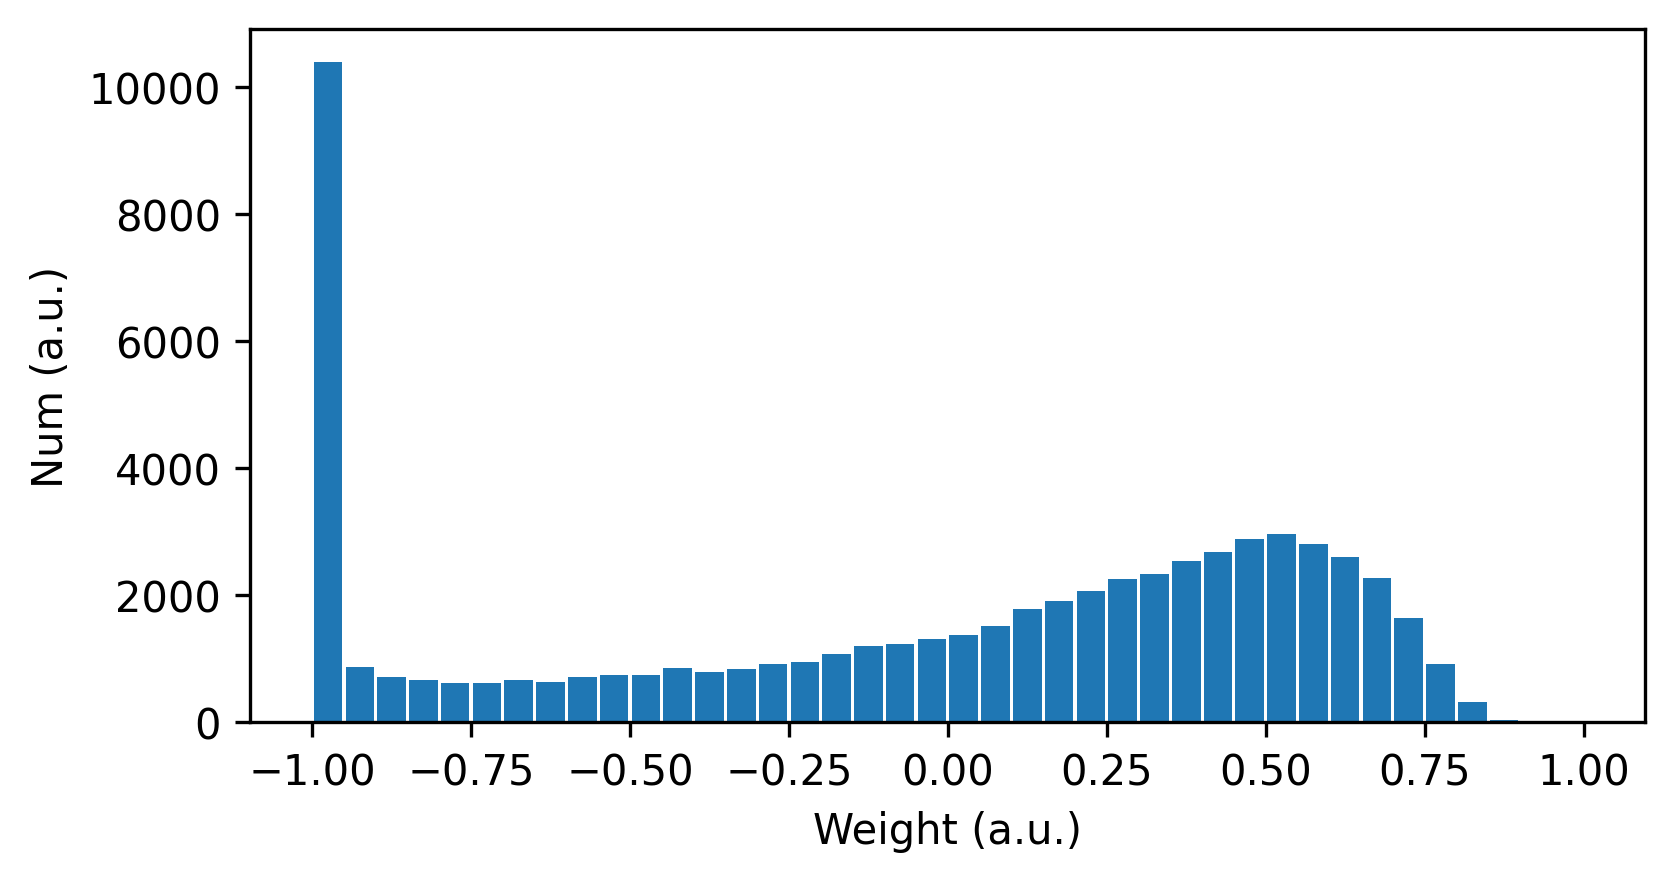

In [55]:
plt.figure(dpi=300,figsize=(6,3))
plt.hist(lorentzian_curve(total_weight, A=1, x0=0, gamma=0.15),bins=40,range=(-1,1),rwidth=0.9)
plt.xlabel('Weight (a.u.)')
plt.ylabel('Num (a.u.)')
plt.show()

In [56]:
file_name = '.\Sensitivity analysis/SAT_Lorentz-rho-1E-4.pth'
if os.path.exists(file_name):
    print('file exist, save failed')
else:
    torch.save(net_Lorentz.state_dict(), file_name)
    print('save done')

save done


In [57]:
PATH = '.\Sensitivity analysis/SAT_Lorentz-rho-1E-4.pth'
net = LeNet5()
net.load_state_dict(torch.load(PATH))
net_Lorentz = LeNet5_Lorentz()
net_Lorentz.load_state_dict(torch.load(PATH))
PATH = ""

In [58]:
net.conv1.weight.data = lorentzian_curve(net_Lorentz.conv1.weight.data, A=1, x0=0, gamma=0.15)
net.conv2.weight.data = lorentzian_curve(net_Lorentz.conv2.weight.data, A=1, x0=0, gamma=0.15)
net.fc1.weight.data = lorentzian_curve(net_Lorentz.fc1.weight.data, A=1, x0=0, gamma=0.15)
net.fc2.weight.data = lorentzian_curve(net_Lorentz.fc2.weight.data, A=1, x0=0, gamma=0.15)
net.fc3.weight.data = lorentzian_curve(net_Lorentz.fc3.weight.data, A=1, x0=0, gamma=0.15)

In [59]:
file_name = '.\Sensitivity analysis/SAT-rho-1E-4.pth'
if os.path.exists(file_name):
    print('file exist, save failed')
else:
    torch.save(net.state_dict(), file_name)
    print('save done')

save done


In [ ]:
### Results
### rho 1e-32 1e-4 1e-3 1e-2 1e-1 1e0 1e1 1e2
### lambda_max 1302.03 1436.56 1375.85 1333.86 64.21 218.51 1614.68 7821.81
### accu 99.0% 99.1% 99.0% 98.9% 99.2% 99.0% 88.6% 38.3%    

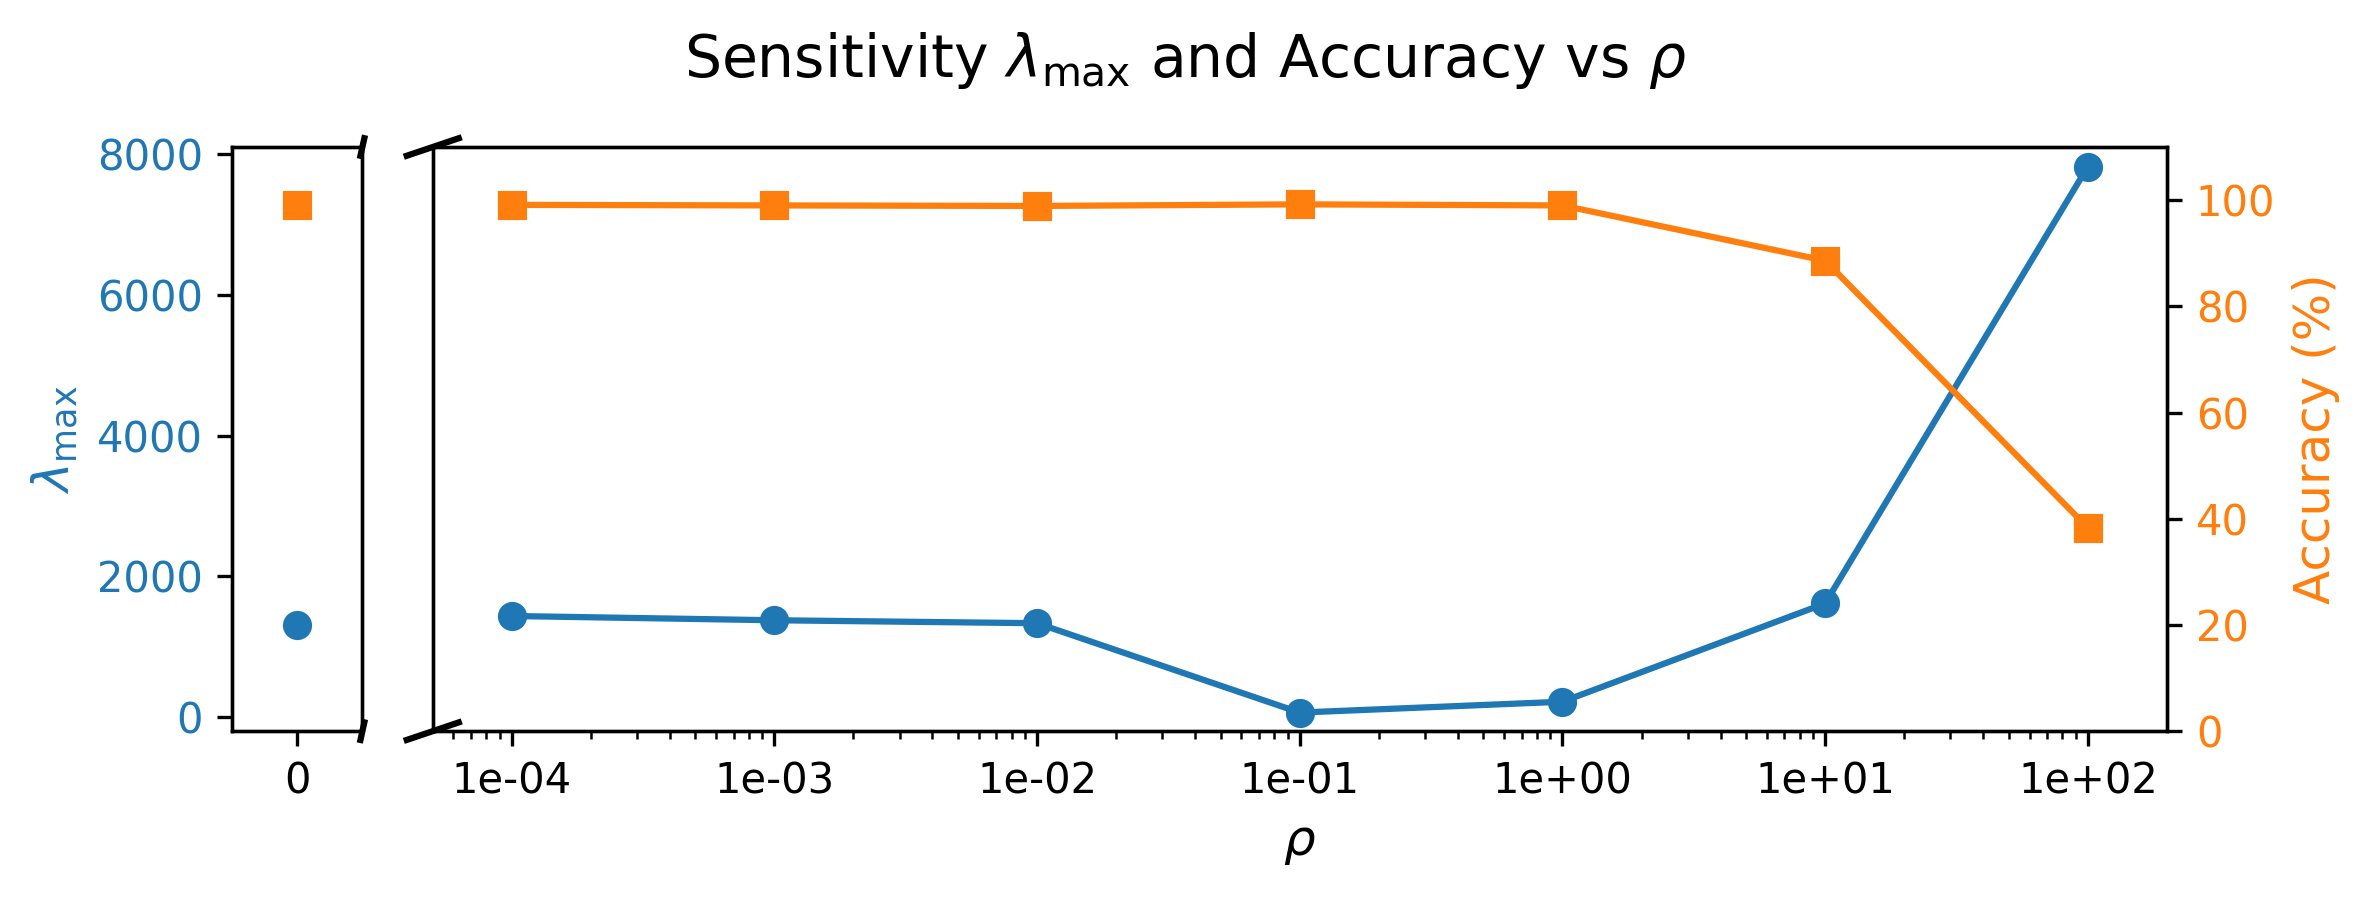

In [35]:
import matplotlib.pyplot as plt
import numpy as np

rho_values = [1e-32, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
lambda_max_values = [1302.03, 1436.56, 1375.85, 1333.86, 64.21, 218.51, 1614.68, 7821.81]
accu_values = [99.0, 99.1, 99.0, 98.9, 99.2, 99.0, 88.6, 38.3]

rho_values_left = [0] 
lambda_left = [lambda_max_values[0]]
accu_left = [accu_values[0]]

rho_values_right = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
lambda_right = lambda_max_values[1:]
accu_right = accu_values[1:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=300, sharey=False, 
                               gridspec_kw={'width_ratios': [0.3, 4]})

color1 = '#1f77b4'
color2 = '#ff7f0e'

# ========== Left ==========
ax1.plot(rho_values_left, lambda_left, marker='o', color=color1)
ax1.set_ylabel(r'$\lambda_{\max}$', color=color1, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color1)
# ax1.set_xlabel('rho', fontsize=12)
ax1.set_ylim([-200,8100])

ax1_2 = ax1.twinx()
ax1_2.plot(rho_values_left, accu_left, marker='s', color=color2)
# ax1_2.set_ylabel('accuracy (%)', color=color2, fontsize=12)
# ax1_2.tick_params(axis='y', labelcolor=color2)
ax1_2.set_ylim([0,110])

ax1.set_xticks([0])
ax1.set_xticklabels(['0'])

# ========== Right ==========
ax2.set_xscale('log')
ax2.plot(rho_values_right, lambda_right, marker='o', color=color1)
ax2.set_xlabel(r'$\rho$', fontsize=12)
ax2.tick_params(axis='x', labelrotation=0)
ax2.set_ylim([-200,8100])

ax2_2 = ax2.twinx()
ax2_2.plot(rho_values_right, accu_right, marker='s', color=color2)
ax2_2.set_ylabel('Accuracy (%)', color=color2, fontsize=12)
ax2_2.tick_params(axis='y', labelcolor=color2)
ax2_2.set_ylim([0,110])

ax2.set_xticks(rho_values_right)
ax2.set_xticklabels([f'{x:.0e}' for x in rho_values_right])
d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax1_2.tick_params(left=False, right=False, labelleft=False, labelright=False)
ax2.tick_params(left=False, labelleft=False)

fig.suptitle(r'Sensitivity $\lambda_{\max}$ and Accuracy vs $\rho$', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

plt.show()
